# Reconocimiento de Patrones en imagenes - Tarea 2 

Este notebook realiza un análisis completo sobre una imagen (`rice.png`), incluyendo:
- Conversión y visualización en distintos formatos.
- Cálculo de color promedio.
- Umbralización y etiquetado de regiones.
- Extracción de descriptores geométricos y de contraste.
- Cálculo de momentos invariantes de Hu.

A lo largo del proceso se explican las operaciones y los resultados obtenidos.


## 1. Carga y visualización de la imagen

En esta sección se carga la imagen `rice.png` utilizando OpenCV, se convierte de BGR a RGB para una correcta visualización y se obtiene su versión en escala de grises.  
Esto permite simplificar el análisis posterior y visualizar las diferencias entre ambas representaciones.


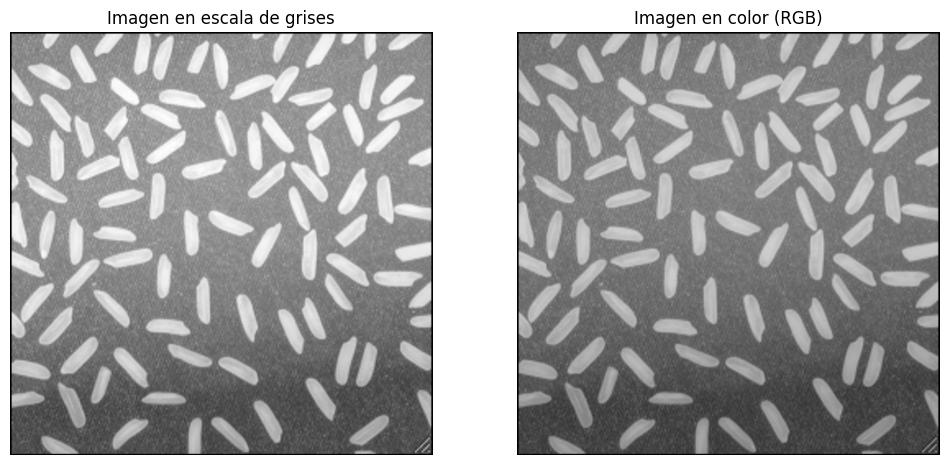

In [1]:
# Importar librerías para procesamiento y visualización de imágenes
import cv2  # OpenCV: carga y operaciones sobre imágenes
import matplotlib.pyplot as plt  # Para mostrar imágenes y gráficos

# Cargar la imagen en color (BGR en OpenCV)
img = cv2.imread('rice.png')  # ruta relativa a la carpeta del notebook

rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB para visualización correcta

# Convertir la imagen a escala de grises para simplificar el análisis
# Esto reduce la dimensionalidad y facilita operaciones como umbralizado
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Mostrar la imagen en escala de grises y rgb usando matplotlib
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(gray, cmap='gray')  # cmap='gray' para visualizar en escala de grises
ax1.set_title('Imagen en escala de grises')
ax1.axis('off')  # ocultar ejes para una visualización limpia
ax2.imshow(rgb)  # Mostrar la imagen RGB
ax2.set_title('Imagen en color (RGB)')
ax2.axis('off')  # ocultar ejes para una visualización limpia
plt.show()

## 2. Cálculo del color promedio

A continuación, se calcula el color promedio de la imagen en formato RGB.  
Esto entrega una medida general del tono dominante en la imagen, útil para caracterizar su composición cromática.


In [2]:
import numpy as np

# Función para calcular el color promedio de una imagen
def color_promedio(im):
    b, g, r = cv2.split(im)
    area = r.shape[0]*r.shape[1]
    prom_r = np.sum(r)/area
    prom_g = np.sum(g)/area
    prom_b = np.sum(b)/area
    return prom_r, prom_g, prom_b

prom = color_promedio(rgb)

print('color promedio (R,G,B):', prom)

color promedio (R,G,B): (np.float64(126.48017128755988), np.float64(126.48017128755988), np.float64(126.48017128755988))


## 3. Umbralización (Binarización) de la imagen

Se aplica un umbral binario inverso para separar los objetos (granos de arroz o letras) del fondo.  
El objetivo es generar una imagen binaria donde el foreground (regiones de interés) esté en blanco y el fondo en negro, facilitando la segmentación posterior.


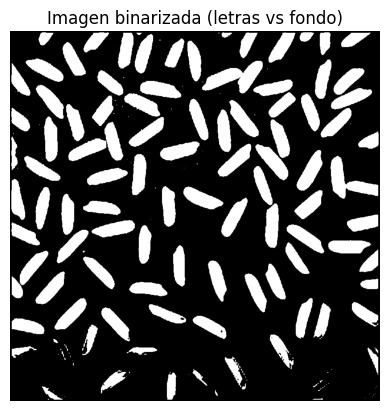

In [3]:
# Aplicar umbral binario inverso para separar letras del fondo
# cv2.threshold devuelve (retorno, imagen_umbralizada). THRESH_BINARY_INV invierte la máscara
ret, bw = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

# invertir la imagen binarizada para que las letras sean el foreground (blanco)
bw = cv2.bitwise_not(bw)

# Mostrar la imagen binarizada. Las letras deberían aparecer en blanco (foreground).
plt.figure()
plt.imshow(bw, cmap='gray')
plt.title('Imagen binarizada (letras vs fondo)')
plt.axis('off')
plt.show()

## 4. Etiquetado y análisis de regiones

Se emplea la función `label` de `skimage.measure` para asignar una etiqueta a cada objeto detectado en la imagen binaria.  
Luego, mediante `regionprops`, se extraen propiedades geométricas y estadísticas de cada región, como su área, perímetro o coordenadas.


Número de regiones detectadas: 183


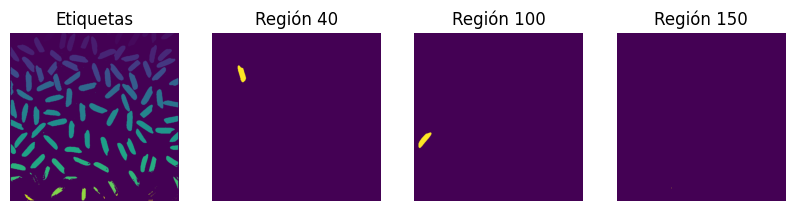

In [4]:
# Importar funciones para etiquetado y análisis de regiones
from skimage.measure import label, regionprops  # label: etiquetar, regionprops: extraer propiedades
import numpy as np

# Etiquetar cada objeto en la imagen binaria (cada objeto recibe un entero distinto)
eq = label(bw)

# Extraer propiedades de las regiones etiquetadas (lista de objetos con atributos)
sts = regionprops(label_image=eq)

# Convertir la matriz de etiquetas a un array de NumPy para facilitar su manipulación
eq = np.array(eq)

# Imprimir el número de regiones detectadas (valor máximo de etiqueta)
print('Número de regiones detectadas:', np.max(eq))

# Visualizar etiquetas y algunos ejemplos concretos (etiqueta 10 y 20) para inspección
fig, ax = plt.subplots(nrows=1, ncols=4)
fig.set_figwidth(10)
ax[0].imshow(eq)  # mapa de etiquetas (cada etiqueta es un entero)
ax[0].set_title('Etiquetas')
ax[1].imshow(eq == 40)  # máscara booleana para la etiqueta 40
ax[1].set_title('Región 40')
ax[2].imshow(eq == 100)  # máscara booleana para la etiqueta 
ax[2].set_title('Región 100')
ax[3].imshow(eq == 150)  # máscara booleana para la etiqueta 150
ax[3].set_title('Región 150')
for a in ax:
    a.axis('off')
plt.show()

## 5. Cálculo del gradiente promedio por perímetro

Se define una función que estima el gradiente en el contorno de cada región.  
Este descriptor cuantifica el cambio de intensidad alrededor del borde, lo que puede relacionarse con la nitidez o el contraste local de los objetos.


In [5]:
from math import sqrt

def gradiente(i,j,L):
    Lx= -0.5*L[i-1,j]+0.5*L[i+1,j]
    Ly= -0.5*L[i,j-1]+0.5*L[i,j+1]
    out= sqrt(Lx**2+Ly**2)
    return out

def gradiente_perimetro(I, J, im):
    #% Descriptor de gradiente perimetro
    #% promedio
    n = len(I)
    out = 0
    for i in range(0, n):
        out += gradiente(I[i],J[i],im)
    return float(out/n)

# calcular gradiente promedio para cada region
grads = []
for region in sts:
    # obtener coordenadas de la frontera de la region
    coords = region.coords
    I = coords[:, 0]
    J = coords[:, 1]
    grad = gradiente_perimetro(I, J, bw)
    grads.append(grad)

## 6. Cálculo de contraste de región (K1, K2, K3)

Aquí se implementa una función que evalúa el contraste entre cada región y su entorno inmediato, utilizando tres métricas (K1, K2 y K3).  
El contraste mide qué tan distinta es la región respecto a su fondo, un factor importante en segmentación y reconocimiento.


In [6]:
def contraste_region(region, imagen_gray):
    minr, minc, maxr, maxc = region.bbox
    h = maxr - minr
    w = maxc - minc

    # Definir entorno (el doble de alto y ancho que la región)
    eminr = max(int(minr - h/2), 0)
    eminc = max(int(minc - w/2), 0)
    emaxr = min(int(eminr + 2*h), imagen_gray.shape[0])
    emaxc = min(int(eminc + 2*w), imagen_gray.shape[1])

    entorno = imagen_gray[eminr:emaxr, eminc:emaxc]
    region_mask = region.image
    entorno_mask = np.ones_like(entorno, dtype=bool)

    # Colocar región dentro del entorno y eliminarla de la máscara del entorno
    r0 = int(minr - eminr)
    c0 = int(minc - eminc)
    entorno_mask[r0:r0+h, c0:c0+w] = np.logical_not(region_mask)

    # Cálculo de promedios
    GE = np.mean(entorno[entorno_mask])
    GR = np.mean(imagen_gray[minr:maxr, minc:maxc][region_mask])

    # Evitar divisiones por cero
    if GE == 0 or GR == 0:
        return (0, 0, 0)

    K1 = (GR - GE) / GE
    K2 = (GR - GE) / (GR + GE)
    K3 = np.log(GR / GE)
    return (K1, K2, K3)

# Calcular contraste para cada región
contrastes = []
for region in sts:
    Ks = contraste_region(region, bw)
    contrastes.append(Ks)

## 7. Cálculo de momentos invariantes de Hu

Los momentos de Hu son descriptores de forma que permanecen invariantes ante rotación, traslación y escala.  
Permiten comparar regiones o reconocer objetos basándose únicamente en su geometría.


In [7]:
def momentos_hu_region(region, im):
    # Extraer subimagen y máscara
    minr, minc, maxr, maxc = region.bbox
    subimg = im[minr:maxr, minc:maxc].astype(np.float64) / 255.0
    mask = region.image

    # Coordenadas de píxeles dentro de la región
    coords = np.column_stack(np.nonzero(mask))
    i_coords = coords[:, 0]
    j_coords = coords[:, 1]

    # Niveles de gris en los píxeles de la región
    valores = subimg[i_coords, j_coords]

    # Momentos espaciales
    m00 = np.sum(valores)
    if m00 == 0:
        return (0, 0, 0)

    m10 = np.sum(i_coords * valores)
    m01 = np.sum(j_coords * valores)

    # Centro de masa
    i_bar = m10 / m00
    j_bar = m01 / m00

    # Momentos centrales
    mu20 = np.sum(((i_coords - i_bar) ** 2) * valores)
    mu02 = np.sum(((j_coords - j_bar) ** 2) * valores)
    mu11 = np.sum((i_coords - i_bar) * (j_coords - j_bar) * valores)
    mu30 = np.sum(((i_coords - i_bar) ** 3) * valores)
    mu03 = np.sum(((j_coords - j_bar) ** 3) * valores)
    mu12 = np.sum((i_coords - i_bar) * ((j_coords - j_bar) ** 2) * valores)
    mu21 = np.sum(((i_coords - i_bar) ** 2) * (j_coords - j_bar) * valores)

    # Momentos normalizados
    eta20 = mu20 / (m00 ** (1 + (2 / 2)))
    eta02 = mu02 / (m00 ** (1 + (2 / 2)))
    eta11 = mu11 / (m00 ** (1 + (2 / 2)))
    eta30 = mu30 / (m00 ** (1 + (3 / 2)))
    eta03 = mu03 / (m00 ** (1 + (3 / 2)))
    eta12 = mu12 / (m00 ** (1 + (3 / 2)))
    eta21 = mu21 / (m00 ** (1 + (3 / 2)))

    # Momentos de Hu
    phi1 = eta20 + eta02
    phi2 = (eta20 - eta02) ** 2 + 4 * (eta11 ** 2)
    phi3 = (eta30 - 3 * eta12) ** 2 + (3 * eta21 - eta03) ** 2

    return (phi1, phi2, phi3)

# Calcular momentos de Hu para cada región
momentos_hu = []
for region in sts:
    phi = momentos_hu_region(region, bw)
    momentos_hu.append(phi)

## 8. Resultados combinados

Finalmente, se muestran los valores obtenidos para cada región:
- **Gradiente promedio**
- **Contrastes K1, K2, K3**
- **Momentos de Hu φ1, φ2, φ3**

Estos descriptores permiten caracterizar cuantitativamente la forma, borde y contraste de cada objeto identificado en la imagen.


In [8]:
# Mostrar resultados combinados (gradiente, contraste y momentos)
for i, (grad, Ks, phi) in enumerate(zip(grads, contrastes, momentos_hu)):
    print(f"Región {i+1}: grad={grad:.3f}, K1={Ks[0]:.3f}, K2={Ks[1]:.3f}, K3={Ks[2]:.3f}, φ1={phi[0]:.5f}, φ2={phi[1]:.5f}, φ3={phi[2]:.5f}")

Región 1: grad=20.927, K1=0.000, K2=0.000, K3=0.000, φ1=0.18264, φ2=0.00490, φ3=0.00103
Región 2: grad=15.705, K1=5.631, K2=0.738, K3=1.892, φ1=0.22423, φ2=0.02325, φ3=0.00022
Región 3: grad=42.240, K1=229.250, K2=0.991, K3=5.439, φ1=0.22690, φ2=0.02085, φ3=0.00287
Región 4: grad=16.534, K1=2.691, K2=0.574, K3=1.306, φ1=0.24128, φ2=0.03005, φ3=0.00112
Región 5: grad=13.591, K1=4.828, K2=0.707, K3=1.763, φ1=0.25896, φ2=0.04040, φ3=0.00008
Región 6: grad=23.043, K1=12.267, K2=0.860, K3=2.585, φ1=0.18137, φ2=0.00594, φ3=0.00050
Región 7: grad=17.289, K1=3.583, K2=0.642, K3=1.522, φ1=0.21217, φ2=0.01754, φ3=0.00058
Región 8: grad=16.988, K1=19.863, K2=0.909, K3=3.038, φ1=0.24926, φ2=0.03459, φ3=0.00116
Región 9: grad=12.966, K1=3.018, K2=0.601, K3=1.391, φ1=0.26547, φ2=0.04415, φ3=0.00004
Región 10: grad=82.917, K1=0.000, K2=0.000, K3=0.000, φ1=0.23021, φ2=0.02196, φ3=0.00319
Región 11: grad=127.500, K1=0.000, K2=0.000, K3=0.000, φ1=0.17188, φ2=0.00610, φ3=0.00343
Región 12: grad=12.930, K

## 9. Interpretación de resultados y efecto del ruido en el etiquetado

El análisis realizado sobre la imagen `rice.png` permitió extraer descriptores de forma, contraste y gradiente para cada región detectada.  
En general, se observa que **muchas regiones presentan valores similares** en los parámetros `grad`, `K1`, `K2`, `K3` y `φ1–φ3`.  
Esto tiene sentido, ya que los **granos de arroz poseen una forma, tamaño y textura relativamente homogéneos**, por lo que sus propiedades locales deberían ser comparables entre sí.

Sin embargo, también se identifican **etiquetas con valores atípicos o significativamente distintos**, sobre todo hacia las **últimas regiones** del listado.  
Estas diferencias se deben principalmente a:

- **Ruido en la imagen original**: el fondo no es completamente uniforme y existen zonas con variaciones de iluminación o textura.  
- **Umbralización imperfecta**: el valor de umbral (`threshold = 150`) pudo haber generado regiones artificiales, fusionadas o fragmentadas, afectando la segmentación real de los granos.  
- **Mal etiquetado de regiones pequeñas**: el algoritmo `label()` considera cualquier agrupación de píxeles blancos como una región válida, por lo que el ruido o pequeños reflejos terminan siendo interpretados como objetos independientes.

En consecuencia, los **datos que se repiten** corresponden a los **granos correctamente segmentados**, reflejando su similitud estructural y de contraste,  
mientras que las **regiones aisladas o con valores incoherentes** representan **artefactos del ruido o errores de umbralización**.  
